# Prédiction de l'action du joueur de Tennis

**Lire les donées**

In [2]:
# Lecture des données

import numpy as np
from PIL import Image 
import glob
import cv2

# Label de la sortie
# 0 : cd
# 1 : rv
# 2 : sm
# 3 : sv

# 0 : rv
# 1 : rv_slice
# 2 : rv_vol
# 3 : rv_2_main
# 4 : cd_flat
# 5 : cd_OS
# 6 : cd_slice
# 7 : cd_vol
# 8 : sv_flat 
# 9 : sv_kick
# 10: sv_slice
# 11: sm

action_size = 12
data_size = 150
frame_size = 15
action_list = [0, 4, 8]
X = []
X_cnn = []
y = []
for k in action_list: # range(action_size): # chaque action
    for i in range(data_size): # chaque vidéo est une données
        D = []
        I = cv2.imread("F:/Tennis/prediction/frame_0.jpg")
        I = cv2.resize(I, (16, 12))
        for image in glob.glob(f"F:/Tennis/prediction/ac{k}/vid ({i})/*.jpg"): # for j in range(frame_size): # chaque frame est une variable, 16*12 * 15 = 2880
            # img = PIL.Image.open(f"F:/Tennis/prediction/ac{k}/vid ({i})/frame_0{j}.jpg").convert("L")
            img = Image.open(image).convert("L")
            img = img.resize((16, 12))
            imgarr = np.array(img)
            img_row = imgarr.reshape(-1) # transformer en ligne
            D = np.append(D, img_row)
            img = cv2.imread(image) # (longueur, hauteur, channel)
            img = cv2.resize(img, (16, 12)) # (int(img.shape[0] / 40), int(img.shape[1] / 40)))
            I = np.hstack((I, img))
            # image = np.vstack((img1, img2)) # concaténation verticale des frames
            # image = np.hstack((img1, img2)) # concaténation horizontale des frames
        X.append(D)
        X_cnn.append(I)
        y.append(k/4)
X = np.array(X)
X_cnn = np.array(X_cnn)
y = np.array(y)

In [3]:
# Visualisation des données

print(len(X))
print(X.shape, X[20].shape, X[21][2833])
print(type(X), type(X[0]), type(X[0][0]))
print(len(X_cnn))
print(X_cnn.shape, X_cnn[20].shape, X_cnn[21][6].shape)
print(type(X_cnn), type(X_cnn[0]), type(X_cnn[0][0]))
print(len(y))
print(y.shape, y[101])
print(type(y), type(y[101]))

450
(450, 2880) (2880,) 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
450
(450, 12, 256, 3) (12, 256, 3) (256, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
450
(450,) 0.0
<class 'numpy.ndarray'> <class 'numpy.float64'>


In [4]:
# Préparation de l'ensemble de test

import numpy as np
import PIL
from PIL import Image 
test_size = 15
frame_size = 15
X_test = []
X_test_cnn = []

# [0 0 0 0 0 4 4 4 4 4 8 8 8 8 8]

for i in range(test_size): # chaque vidéo est une données
        T = []
        I = cv2.imread("F:/Tennis/prediction/frame_0.jpg")
        I = cv2.resize(I, (16, 12))
        for image in glob.glob(f"F:/Tennis/prediction/test/test{i}/*.jpg"): # for j in range(frame_size): # chaque frame est une variable, 16*12 * 15 = 2880
            # img = PIL.Image.open(f"F:/Tennis/prediction/test/test{i}/frame_{j}.jpg").convert("L")
            img = Image.open(image).convert("L")
            img = img.resize((16, 12))
            imgarr = np.array(img)
            img_row = imgarr.reshape(-1) # transformer en ligne
            T = np.append(T, img_row)
            img = cv2.imread(image) # (longueur, hauteur, channel)
            img = cv2.resize(img, (16, 12)) # (int(img.shape[0] / 40), int(img.shape[1] / 40)))
            I = np.hstack((I, img))
        X_test.append(T)
        X_test_cnn.append(I)
X_test = np.array(X_test)
X_test_cnn = np.array(X_test_cnn)
print(X_test.shape)
print(X_test_cnn.shape)

(15, 2880)
(15, 12, 256, 3)


In [5]:
# Test de la compression des images

import cv2

img = cv2.imread('frame_0.jpg')
print(img.shape)
#x, y = img.shape[0:2]
# cv2.imshow('OriginalPicture', img)
 
img_test1 = cv2.resize(img, (int(img.shape[0] / 40), int(img.shape[1] / 40)))
print(img_test1.shape)
# cv2.imshow('resize0', img_test1)

img = PIL.Image.open("F:/Tennis/prediction/frame_0.jpg").convert("L") # L = R * 299/1000 + G * 587/1000 + B * 114/1000 # ("RGB")
img = img.resize((20, 20))
img = img.save("F:/Tennis/prediction/frame_0_test.jpg")

(480, 640, 3)
(16, 12, 3)


**K-means**

In [27]:
# from sklearn.cluster import KMeans
# import numpy as np
# import matplotlib.pyplot as plt

# X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
# kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X, y)
# kmeans.labels_
# kmeans.predict([[0, 0], [12, 3]])
# kmeans.cluster_centers_

# plt.scatter(X, y, c=kmeans.labels_)
# plt.show()

**Réseaux de neurones**

In [19]:
# Construction du model avec tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model = Sequential(
    [               
        tf.keras.Input(shape = 2880), # 16*12 * 15 = 2880
        Dense(units=16, activation="relu"),
        Dense(units=32, activation="relu"),
        Dense(units=64, activation="sigmoid"),
        Dense(units=128, activation="relu"),
        Dense(units=3, activation="softmax"),
    ]
)          
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                46096     
                                                                 
 dense_14 (Dense)            (None, 32)                544       
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 57,459
Trainable params: 57,459
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model.compile(
    #optimizer = 'RMSprop', loss = 'categorical_crossentropy', metrics = ['acc']
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # 'Adam',
    metrics=['accuracy']
)

history = model.fit(
    X, y,
    epochs = 50,
    # batch_size = 32 # données transmises pour une session
)

prediction = model.predict(X_test) # np.expand_dims(X_test, axis = 1)
print (prediction)
# prediction_p = tf.nn.softmax(prediction)
# yhat = np.argmax(prediction)

# Softmax
# def softmax(z):  
#     ez = np.exp(z)
#     a = ez/np.sum(ez)
#     return a


Epoch 1/50
15/15 [==============================] - 1s 1ms/step - loss: 1.1244 - accuracy: 0.3378
Epoch 2/50
15/15 [==============================] - 0s 1ms/step - loss: 1.0938 - accuracy: 0.3622
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 1.0531 - accuracy: 0.4400
Epoch 4/50
15/15 [==============================] - 0s 1ms/step - loss: 0.9624 - accuracy: 0.5844
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.8605 - accuracy: 0.6422
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.7216 - accuracy: 0.7511
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.7800
Epoch 8/50
15/15 [==============================] - 0s 1ms/step - loss: 0.5085 - accuracy: 0.8289
Epoch 9/50
15/15 [==============================] - 0s 1ms/step - loss: 0.5515 - accuracy: 0.7689
Epoch 10/50
15/15 [==============================] - 0s 1ms/step - loss: 0.4775 - accuracy: 0.8200
Epoch 11/50
15/15 [

# [0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8]
# [0, 8, 0, 0, 0, 8, 4, 4, 4, 4, 8, 8, 8, 8, 8]
# 13/15

**Réseau neuronal convolutif**

In [2]:
# construction du modèle

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model_cnn = Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(12, 256, 3)), # kernel_size, strides, padding = 'same'
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Conv2D(128, (3, 3), activation='relu'),
        # BatchNormalization(),
        # MaxPooling2D(pool_size=(2, 2)),
        # Dropout(0.25),
        
        Flatten(),
        # Dense(512, activation='relu'),
        # BatchNormalization(),
        # Dropout(0.5),
        Dense(3, activation='softmax')
    ]
)            
model_cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # loss pour one-hot coding
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 254, 32)       896       
                                                                 
 batch_normalization_3 (Batc  (None, 10, 254, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 127, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 127, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 125, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 3, 125, 64)      

In [13]:
# entraînement du modèle

import tensorflow as tf

history_cnn = model_cnn.fit(
    X_cnn, tf.keras.utils.to_categorical(y, 3), # one-hot coding
    epochs = 50,
)

Epoch 1/50
15/15 [==============================] - 1s 48ms/step - loss: 3.1871 - accuracy: 0.4422
Epoch 2/50
15/15 [==============================] - 1s 48ms/step - loss: 1.0373 - accuracy: 0.6978
Epoch 3/50
15/15 [==============================] - 1s 48ms/step - loss: 1.1371 - accuracy: 0.6644
Epoch 4/50
15/15 [==============================] - 1s 47ms/step - loss: 0.8599 - accuracy: 0.7422
Epoch 5/50
15/15 [==============================] - 1s 46ms/step - loss: 0.4269 - accuracy: 0.8444
Epoch 6/50
15/15 [==============================] - 1s 50ms/step - loss: 0.4851 - accuracy: 0.8200
Epoch 7/50
15/15 [==============================] - 1s 49ms/step - loss: 0.3971 - accuracy: 0.8689
Epoch 8/50
15/15 [==============================] - 1s 51ms/step - loss: 0.3078 - accuracy: 0.8889
Epoch 9/50
15/15 [==============================] - 1s 52ms/step - loss: 0.4316 - accuracy: 0.8511
Epoch 10/50
15/15 [==============================] - 1s 50ms/step - loss: 0.2784 - accuracy: 0.9111
Epoch 11/

In [14]:
# prédiction sur l'ensemble de test

prediction_cnn = model_cnn.predict(X_test_cnn)
print(prediction_cnn)

1/1 [==============================] - 0s 134ms/step
[[2.69260444e-02 9.73071158e-01 2.84077146e-06]
 [8.38717043e-01 1.59975812e-01 1.30718702e-03]
 [1.00000000e+00 6.25001340e-09 1.25824329e-09]
 [9.67974782e-01 3.20112333e-02 1.39610720e-05]
 [9.24357176e-01 7.56428689e-02 1.05627116e-08]
 [1.59981484e-09 9.99574721e-01 4.25284758e-04]
 [1.59956102e-08 9.99999166e-01 8.86341240e-07]
 [1.35899669e-09 1.00000000e+00 1.28263911e-09]
 [9.04301387e-14 1.00000000e+00 2.76226642e-09]
 [7.44924109e-05 9.99925494e-01 4.96791275e-09]
 [5.60752405e-08 3.00664844e-08 9.99999881e-01]
 [1.19550961e-07 2.41216696e-07 9.99999642e-01]
 [3.37134889e-15 3.43483020e-10 1.00000000e+00]
 [2.14642595e-10 2.08238829e-10 1.00000000e+00]
 [1.01106154e-16 2.72035663e-07 9.99999762e-01]]


# [0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8]
# [4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8]
# 13/15

# N.B: Squelette, confusion, position

In [54]:
# Modèle général pour tester les paramètres

# def neural_network(num_layer, units, learning_rate=0.01):
#     """
#     Parameters
#     ----------
#     num_layer       : int
#                     number of layers
#     units           : list
#                     number of units in each layer
#     learning_rate   : float
#                     learning rate of the optimizer of the model
#     """
#     if (len(units) != num_layer):
#         raise ValueError("Number of list of units must be equal to number of layers")
#     model = Sequential()
#     model.add(Dense(units=units[0], input_dim=X_train.shape[1], activation="relu"))
#     for i in range(1, num_layer-1):
#         model.add(Dense(units=units[i], activation="relu"))
#     model.add(Dense(units=1, activation="linear"))
#     model.compile(
#         loss=tf.keras.losses.MeanAbsoluteError(),
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         metrics=[tf.keras.metrics.MeanAbsoluteError()]
#     )
#     return model

In [55]:
# Evaluation des modèle

# histories_neural_network = []
# def neural_network_score(num_layer, units, learning_rate=[0.001, 0.01, 0.1]):
#     """
#     Parameters
#     ----------
#     num_layer       : int
#                     number of layers
#     units           : list
#                     number of units in each layer
#     learning_rate   : list
#                     learning rate of the optimizer of the model
#     """
#     if (len(units) != num_layer):
#         raise ValueError('Le nombre de couches doit être égale à la taille de la liste des neurones')
#     for i in range(len(learning_rate)):
#         model = neural_network(num_layer, units, learning_rate=learning_rate[i])
#         model.save(f"neural_network_model_{i}.h5")
#         history = model.fit(
#             X_train, y_train,
#             epochs=50,
#             batch_size=50,
#             validation_split=0.2
#         )
#         histories_neural_network.append(history)
#         y_pred = model.predict(X_test)
#         y_pred = np.reshape(y_pred, (y_pred.shape[0],))
#         print(f'TEST - R2 score avec le taux {learning_rate[i]} : {r2_score(y_test_numpy, y_pred)}')
#         print(f'TEST - MAE score avec le taux {learning_rate[i]} : {history.history["val_loss"][-1]}')

In [ ]:
# Entraînement des différents modèles

# num_layer = 4
# units = [128, 256, 256, 1]
# neural_network_score(num_layer, units)

In [ ]:
#Visualiser les traces

# from sklearn.metrics import r2_score

# plt.plot(histories_neural_network[0].history['val_loss'])
# plt.plot(histories_neural_network[1].history['val_loss'])
# plt.plot(histories_neural_network[2].history['val_loss'])
# plt.title('Model loss')  
# plt.ylabel('Val Loss')  
# plt.xlabel('Epoch')  
# plt.legend(['taux = 0.001', 'taux = 0.01', 'taux = 0.1'], loc='upper right')  
# plt.show()

In [ ]:
# Test de la performance
#from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#from math import sqrt

# X_test_numpy = np.array(X_test)
# y_test_numpy = np.array(y_test)
# y_pred = model.predict(X_test_numpy)
# y_pred = np.reshape(y_pred, (y_pred.shape[0],))
# plt.scatter(y_test, y_pred, color="b")
# plt.plot(y_test, y_test, color="r")
# r2_nn = r2_score(y_test_numpy, y_pred)
# print('TEST - R2 score - Réseau de neurones: ', r2_nn)

# Nouvelle donnée

In [13]:
# Lecture des données

import numpy as np
from PIL import Image 
import glob
import cv2

# Label de la sortie
# 0 : cd
# 1 : rv
# 2 : sv
# 3 : dp

action_size1 = 4
data_size1 = 40
frame_size1 = 15
action_list1 = [0, 1, 2, 3]
X1 = []
X1_cnn = []
y1 = []
for k in action_list1: # range(action_size): # chaque action
    for i in range(data_size1): # chaque vidéo est une données
        D1 = []
        I1 = cv2.imread("F:/Tennis/prediction/init.jpg")
        I1 = cv2.resize(I1, (50, 50))
        for image in glob.glob(f"F:/Tennis/prediction/data-joueur/JBas/ac{k}/vid ({i})/images/*.jpg"): # chaque frame est une variable # 50*50 * 15
            img1 = Image.open(image).convert("L")
            img1 = img1.resize((50, 50))
            imgarr1 = np.array(img1)
            img_row1 = imgarr1.reshape(-1) # transformer en ligne
            D1 = np.append(D1, img_row1)
            img1 = cv2.imread(image) # (longueur, hauteur, channel)
            img1 = cv2.resize(img1, (50, 50))
            I1 = np.hstack((I1, img1))
        X1.append(D1)
        X1_cnn.append(I1)
        y1.append(k)
X1 = np.array(X1)
print(len(X1_cnn), len(X1_cnn[7]), len(X1_cnn[15][22]), len(X1_cnn[100][25][4]))
# X1_cnn = np.array(X1_cnn)
y1 = np.array(y1)

160 50 800 3


C:\Users\DELL\AppData\Local\Temp\ipykernel_32212\473050630.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X1 = np.array(X1)


In [12]:
# Préparation de l'ensemble de test

import numpy as np
import PIL
from PIL import Image 

test_size1 = 25
frame_size1 = 15
X1_test = []
X1_test_cnn = []

# [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 3 3 3 3 3]

for i in range(test_size1): # chaque vidéo est une données
        T1 = []
        I1 = cv2.imread("F:/Tennis/prediction/init.jpg")
        I1 = cv2.resize(I1, (50, 50))
        for image in glob.glob(f"F:/Tennis/prediction/test_data/vid ({i})/images/*.jpg"): # chaque frame est une variable, 50*50 * 15 = 37500
            img = Image.open(image).convert("L")
            img = img.resize((50, 50))
            imgarr = np.array(img)
            img_row = imgarr.reshape(-1) # transformer en ligne
            T1 = np.append(T1, img_row)
            img = cv2.imread(image) # (longueur, hauteur, channel)
            img = cv2.resize(img, (50, 50)) # (int(img.shape[0] / 40), int(img.shape[1] / 40)))
            I1 = np.hstack((I1, img))
        X1_test.append(T1)
        X1_test_cnn.append(I1)
X1_test = np.array(X1_test)
# X1_test_cnn = np.array(X1_test_cnn)
print(X1_test.shape)
# print(X1_test_cnn.shape)

(25,)


C:\Users\DELL\AppData\Local\Temp\ipykernel_32212\1460255712.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X1_test = np.array(X1_test)


In [17]:
# Construction du model avec tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

model1 = Sequential(
    [               
        tf.keras.Input(shape = 37500), # 50*50 * 15 = 37500
        Dense(units=16, activation="relu"),
        Dense(units=32, activation="relu"),
        Dense(units=64, activation="sigmoid"),
        Dense(units=128, activation="relu"),
        Dense(units=4, activation="softmax"),
    ]
)          
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                600016    
                                                                 
 dense_11 (Dense)            (None, 32)                544       
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 4)                 516       
                                                                 
Total params: 611,508
Trainable params: 611,508
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Entraînement et la prédiction

import tensorflow as tf

model1.compile(
    #optimizer = 'RMSprop', loss = 'categorical_crossentropy', metrics = ['acc']
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # 'Adam',
    metrics=['accuracy']
)

history1 = model1.fit(
    X1, y1,
    epochs = 50,
    # batch_size = 32 # données transmises pour une session
)

prediction1 = model1.predict(X1_test)
print (prediction1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

# -----------------------------------------------------------------------------------------------------------------

**Forêt aléatoire**

In [2]:
# lecture des données

import pandas as pd

df = pd.read_csv("F:/Tennis/trajectoire/pos.csv")
# print(df.info)
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46
0,"(175, 232)","(192, 231)","(194, 236)","(200, 219)","(196, 213)","(209, 215)","(209, 213)","(212, 208)","(222, 191)","(226, 199)",...,"(348, 133)","(354, 135)","(355, 124)","(356, 125)","(366, 114)","(369, 111)","(377, 106)","(374, 102)","(383, 105)",1
1,"(175, 232)","(184, 227)","(195, 229)","(200, 215)","(196, 213)","(206, 214)","(215, 214)","(207, 208)","(217, 194)","(217, 195)",...,"(350, 126)","(358, 136)","(356, 121)","(360, 125)","(370, 119)","(374, 114)","(371, 110)","(380, 108)","(391, 93)",1
2,"(175, 234)","(180, 227)","(187, 223)","(196, 224)","(196, 218)","(198, 213)","(213, 204)","(218, 211)","(222, 197)","(224, 189)",...,"(359, 137)","(347, 129)","(350, 125)","(355, 117)","(364, 121)","(369, 107)","(371, 102)","(373, 102)","(388, 95)",1
3,"(176, 232)","(191, 229)","(188, 233)","(200, 216)","(205, 217)","(208, 210)","(211, 213)","(215, 209)","(221, 196)","(218, 191)",...,"(346, 128)","(354, 124)","(357, 117)","(361, 122)","(364, 121)","(377, 110)","(374, 107)","(383, 97)","(382, 101)",1
4,"(176, 234)","(191, 229)","(193, 234)","(200, 220)","(199, 219)","(205, 216)","(208, 207)","(205, 208)","(214, 191)","(222, 195)",...,"(350, 129)","(348, 134)","(351, 125)","(367, 114)","(362, 112)","(374, 115)","(376, 104)","(382, 96)","(386, 101)",1


In [12]:
# conversion du type

import math as m

def conv(a):  
    a = a[1:len(a) - 1]
    l = a.split(',')
    return m.sqrt(m.pow(float(l[0]), 2) + m.pow(float(l[1]), 2))

a = df['col2'][1]
print(a)
a = a[1:len(a) - 1]
print(type(a))
l = a.split(',')
print(l)
print(type(l))
s = m.sqrt(m.pow(float(l[0]), 2) + m.pow(float(l[1]), 2))
print(s)
print(type(s))

# préparation de l'ensemble

from sklearn.model_selection import train_test_split

X = df.drop('col46', axis=1)
y = df['col46']

data_size = 7271 # 7271
for col in X:
    for lig in range(data_size):
        X[col][lig] = conv(X[col][lig])
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

a = X['col2'][1]
print(a)
print(type(a))
print(type(X), X.shape)

(184, 227)
<class 'str'>
['184', ' 227']
<class 'list'>
292.2071183253413
<class 'float'>
292.2071183253413
<class 'float'>
<class 'pandas.core.frame.DataFrame'> (7271, 45)


<Axes: xlabel='col46', ylabel='count'>

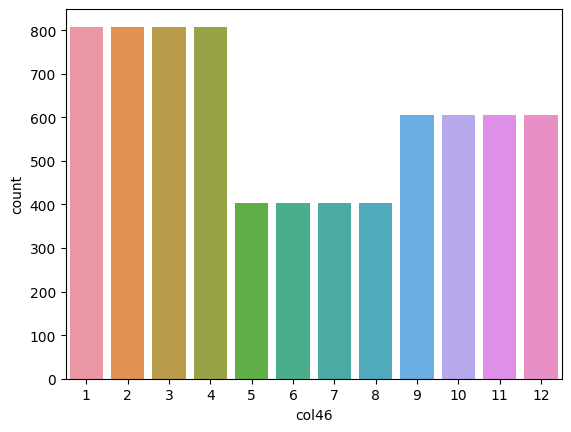

In [13]:
# visualisation

import seaborn as sns

sns.countplot(x='col46', data=df)

In [29]:
# entraînement et prédiction

from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf_clf = RandomForestClassifier(n_estimators = 100)
# max_samples : indique le nombre d'échantillons à tirer des données d'entraînement dans l'échantillonnage Bootstrap. 
# max_depth : indique la profondeur maximale de l'arbre, que nous spécifions si nécessaire.
# n_estimators : indique le nombre d'arbres de décision à créer dans le modèle de forêt aléatoire. Par défaut, il est de 100.
rf_clf.fit(X_train, y_train)

pred = rf_clf.predict(X_test)

# test de la précision

# print(type(np.array(y_test)), y_test.shape)
# print(y_test)
# print(type(pred), pred.shape)
# print(pred)
print(rf_clf.score(X_test, y_test))

<class 'numpy.ndarray'> (1455,)
<class 'numpy.ndarray'> (1455,)
1.0


**Arbre de décision**

In [19]:
# entraînement

from sklearn import tree

# X_train, y_train = X.values, y.values
ad_clf = tree.DecisionTreeClassifier()
ad_clf = ad_clf.fit(X_train, y_train)

In [30]:
# test de la performance

pred = ad_clf.predict(X_test)
print(ad_clf.score(X_test, y_test))

0.940893470790378


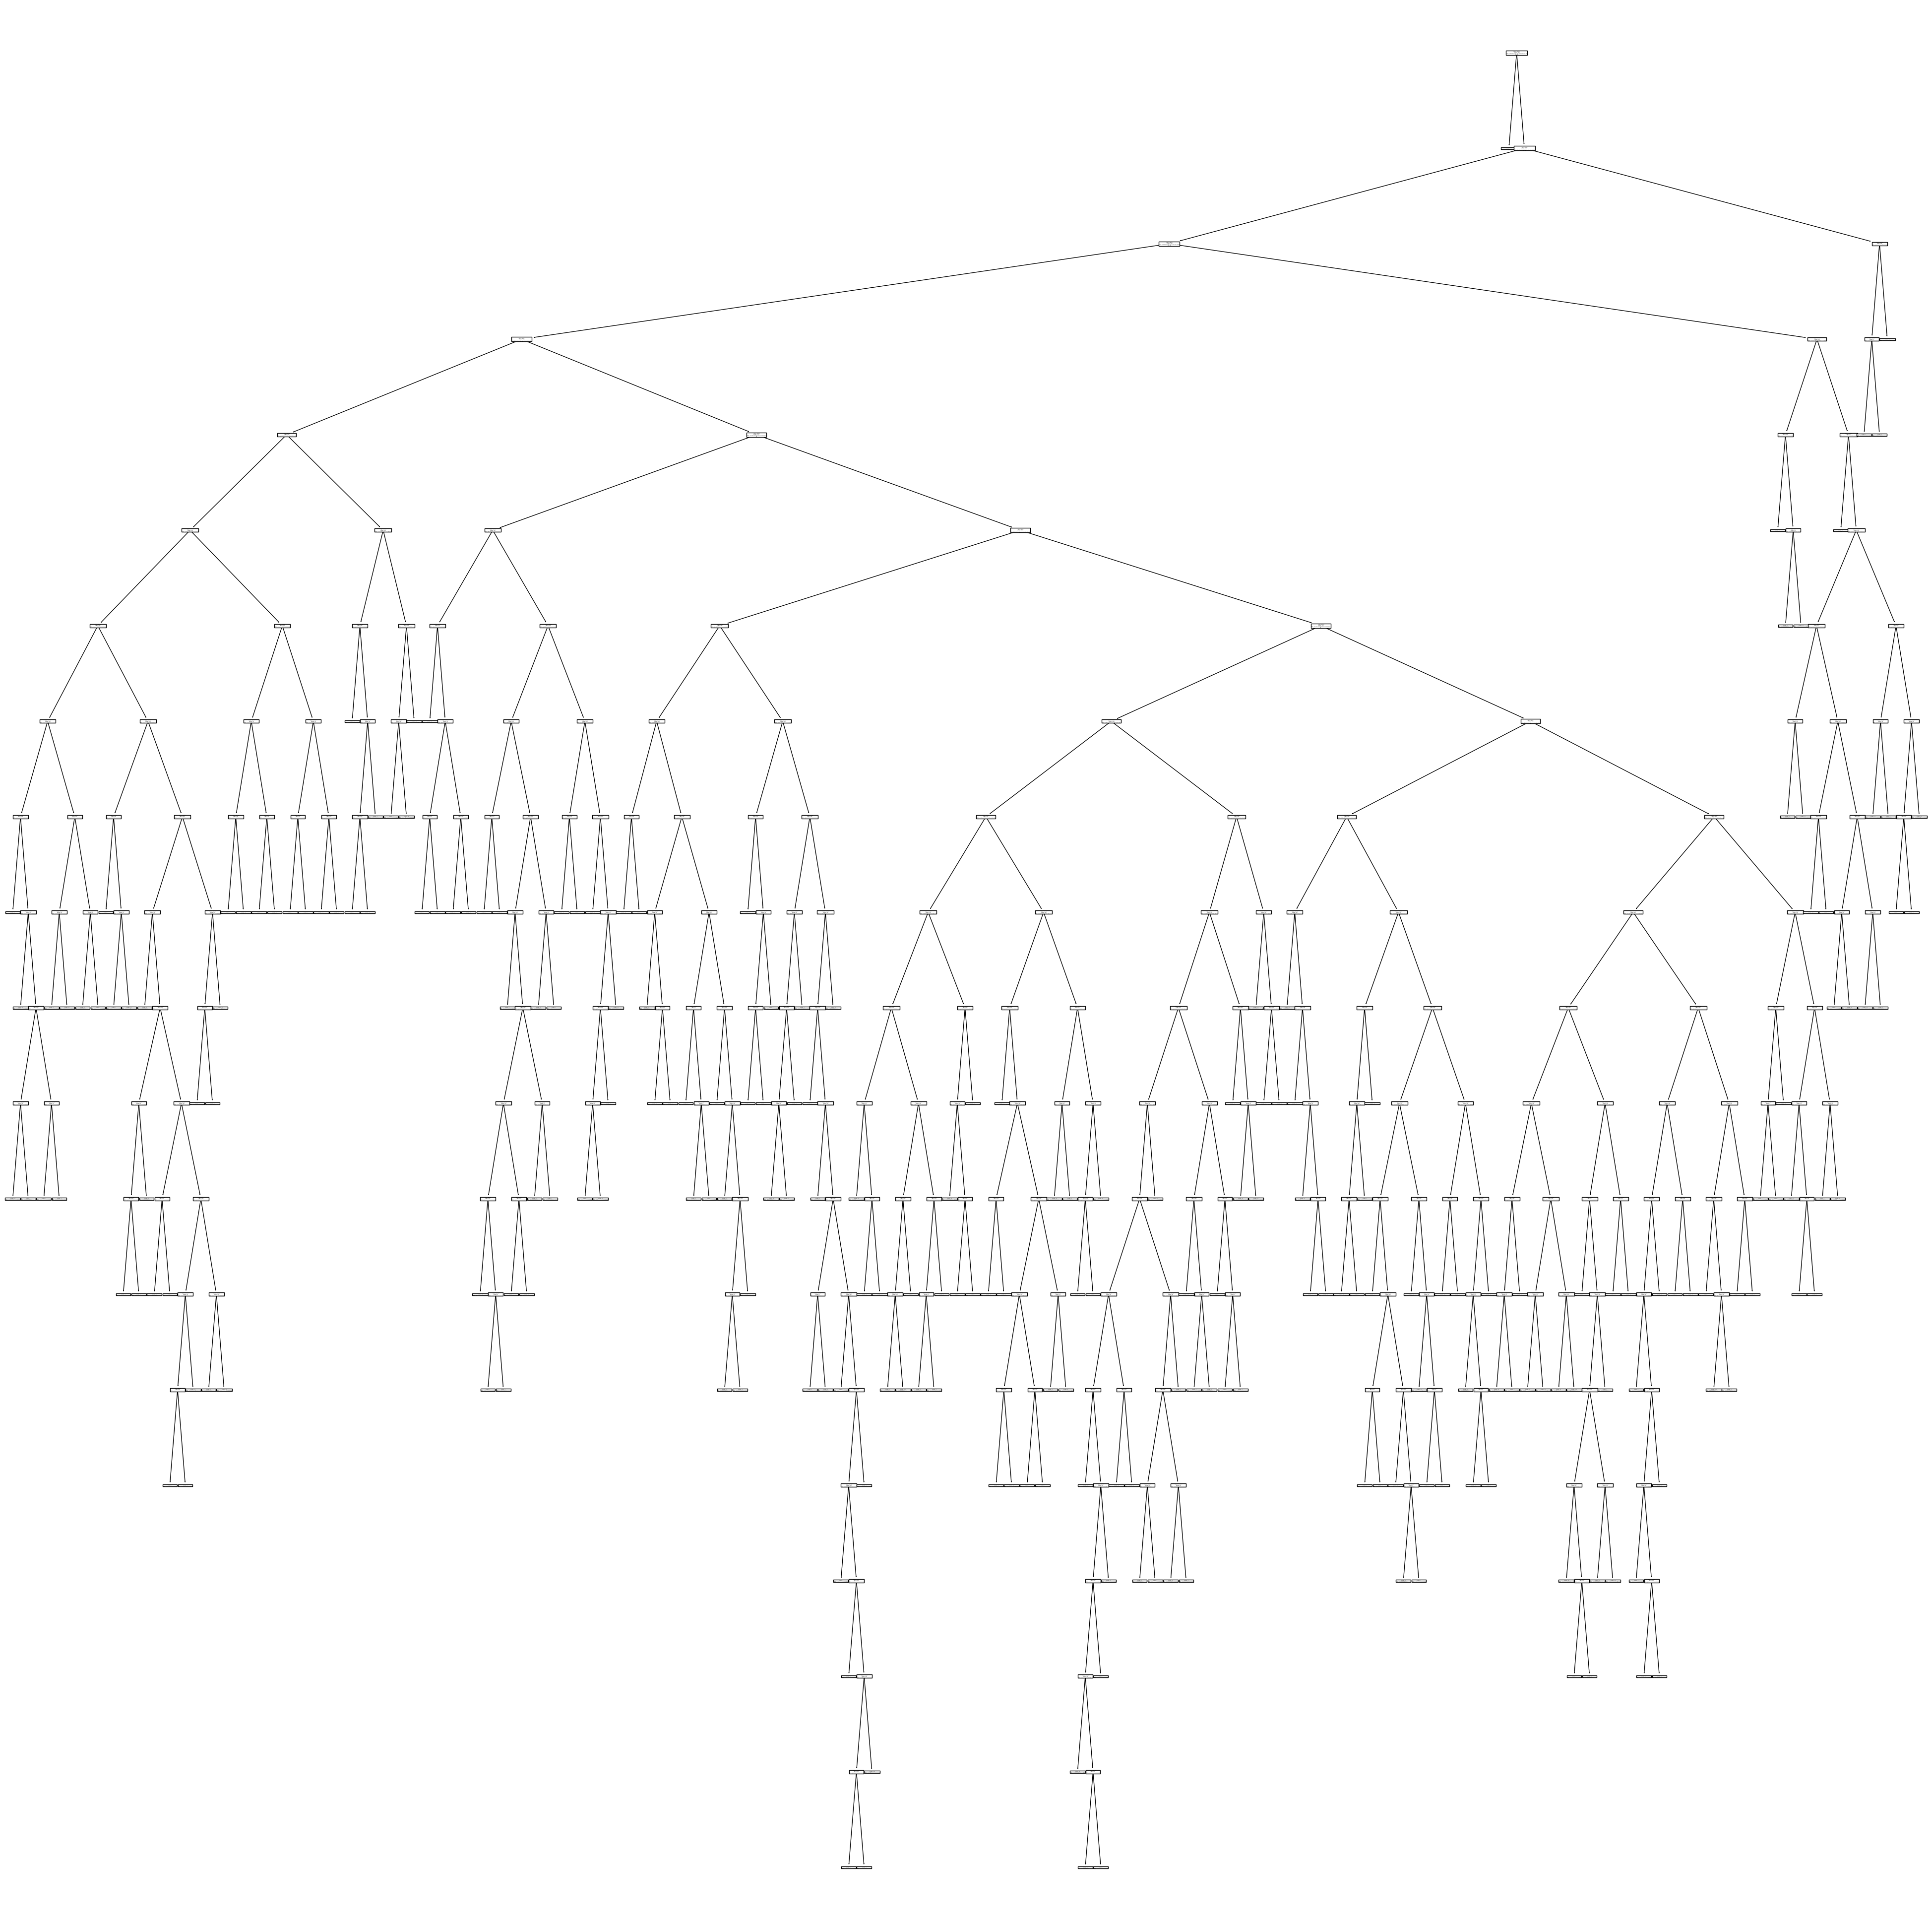

In [22]:
# visualisation de l'arbre

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(50,50))
tree.plot_tree(ad_clf);

# FIN